In [1]:
# project: p6
# submitter: Smwells3
# partner: none
# hours: 9

In [2]:
import sqlite3, math, copy, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import make_column_transformer
from zipfile import ZipFile
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML

In [3]:
#from stackoverflow.com to combat SettingWithCopyWarning
pd.options.mode.chained_assignment = None 

In [4]:
connection = sqlite3.connect("data/images.db")
districts = pd.read_sql("""
SELECT * FROM districts
""", connection)
df = pd.read_sql("""
SELECT file_name, district_name, lon, lat, water_ratio, forest_ratio, agriculture_ratio, developed_ratio 
FROM sample 
INNER JOIN districts ON sample.district_id = districts.district_id 
LIMIT 400
""", connection)
train, test = train_test_split(df, random_state=0)

In [5]:
#q1
test[-5:]

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio
146,area0146.npy,district 08,-87.869312,44.365150,0.0048,0.0249,0.8343,0.0896
135,area0135.npy,district 06,-87.852985,43.935362,0.0030,0.0463,0.8241,0.0697
390,area0390.npy,district 01,-88.908064,42.562049,0.0000,0.1818,0.6871,0.0763
264,area0264.npy,district 01,-87.842951,42.704875,0.0030,0.0376,0.0423,0.8906
364,area0364.npy,district 01,-87.987364,42.754155,0.0025,0.0498,0.8408,0.0689


Text(0, 0.5, 'developed ratio')

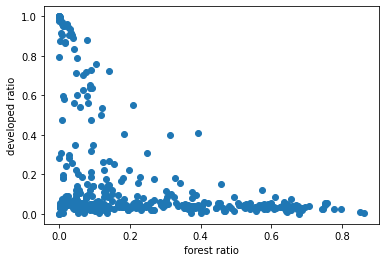

In [6]:
#q2
plt.scatter(df["forest_ratio"], df["developed_ratio"])
plt.xlabel("forest ratio")
plt.ylabel("developed ratio")

In [7]:
#q3
lr = LinearRegression()
lr.fit(train[["lat", "lon", "water_ratio", "forest_ratio", "agriculture_ratio"]], train["developed_ratio"])
test = test.copy()
test["predicted"] = lr.predict(test[["lat", "lon", "water_ratio", "forest_ratio", "agriculture_ratio"]])
test[:5]

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio,predicted
132,area0132.npy,district 06,-87.940213,43.750300,0.0058,0.0266,0.5506,0.2990,0.187514
309,area0309.npy,district 07,-91.854009,45.352143,0.0002,0.1366,0.8074,0.0401,-0.155128
341,area0341.npy,district 01,-88.294035,42.656175,0.0010,0.3283,0.2029,0.1805,0.376093
196,area0196.npy,district 06,-89.557249,44.187877,0.0000,0.0836,0.8079,0.0412,-0.054414
246,area0246.npy,district 05,-88.596203,43.159942,0.0002,0.0201,0.6677,0.0921,0.188176


In [8]:
#q4
lr.score(test[["lat", "lon", "water_ratio", "forest_ratio", "agriculture_ratio"]], test["developed_ratio"])

0.7138077753811825

Text(0, 0.5, 'predicted developed ratio')

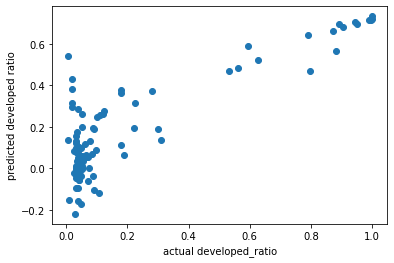

In [9]:
#q5
plt.scatter(test["developed_ratio"], test["predicted"])
plt.xlabel("actual developed_ratio")
plt.ylabel("predicted developed ratio")

<AxesSubplot:xlabel='Feature', ylabel='Coefficient'>

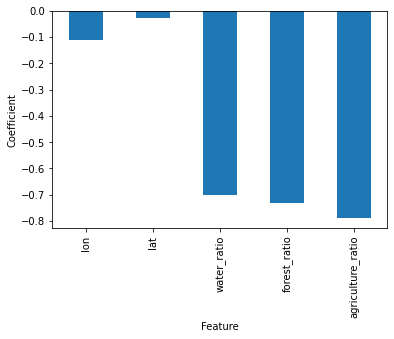

In [10]:
#q6
coefs = lr.coef_
series = pd.Series(coefs, test.keys()[2:7].values, )
series.plot.bar(xlabel="Feature", ylabel="Coefficient")

In [11]:
#q7
pipeline = Pipeline([
    ("both", make_column_transformer((OneHotEncoder(), ["district_name"]), 
                                     (PolynomialFeatures(degree=2, include_bias=False), ["water_ratio", "forest_ratio", "agriculture_ratio"]), remainder="passthrough")),
    ("lr", LinearRegression())
])
pipeline.fit(train[["district_name","lon", "lat","water_ratio", "forest_ratio", "agriculture_ratio"]], train["developed_ratio"])
pipeline.score(test[["district_name","lon", "lat","water_ratio", "forest_ratio", "agriculture_ratio"]], test["developed_ratio"])

0.8420970788505492

In [12]:
#q8
simple_scores = cross_val_score(lr, train[["lon", "lat","water_ratio", "forest_ratio", "agriculture_ratio"]], train["developed_ratio"], cv=8)
complex_scores = cross_val_score(pipeline, train[["district_name","lon", "lat","water_ratio", "forest_ratio", "agriculture_ratio"]], train["developed_ratio"], cv=8)
simple_scores.mean(), complex_scores.mean()

(0.6517545836308132, 0.7882683505969756)

In [13]:
#q9
(math.sqrt(simple_scores.var()), math.sqrt(complex_scores.var()))

(0.11307460959365247, 0.06667525211477915)

In [14]:
df = pd.read_sql("""
SELECT file_name, district_name, lon, lat, water_ratio, forest_ratio, agriculture_ratio, developed_ratio 
FROM sample 
INNER JOIN districts ON sample.district_id = districts.district_id 
""", connection)
train, test = train_test_split(df, random_state=0)

In [15]:
arrays = {}
with ZipFile("data/images.zip") as zf:
    for file in df["file_name"][400:]:
        with zf.open(file) as f:
            arrays[file] = np.load(io.BytesIO(f.read()))
            
def array_count(array, lower, upper):
    total = 0
    for number in range(upper+1)[lower:]:
        total += (array == number).astype(int).mean()
    return total

In [16]:
#q10
(arrays["area1234.npy"] == 52).astype(int).sum()

80

In [17]:
df = df.copy()
index = 400
for file in df["file_name"][400:]:
    water = (arrays[file] == 11).astype(int).mean() 
    forest = array_count(arrays[file], 41, 43) 
    agri = array_count(arrays[file], 81, 82)
    devel = array_count(arrays[file], 21, 24)
    (df["water_ratio"][index], df["forest_ratio"][index], df["agriculture_ratio"][index], df["developed_ratio"][index]) = (water, forest, agri, devel)
    index += 1

In [18]:
(arrays[file] == 11).astype(int).sum()

75

In [19]:
#q11
train, test = train_test_split(df, random_state=0)
test[-5:]

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio
936,area0936.npy,district 03,-92.152574,44.502114,0.0000,0.4248,0.5276,0.0396
1524,area1524.npy,district 02,-90.151901,43.211515,0.0002,0.1870,0.7766,0.0344
1415,area1415.npy,district 05,-88.921017,43.197963,0.0001,0.0543,0.6463,0.0305
1223,area1223.npy,district 04,-87.906383,43.074510,0.0145,0.0169,0.0060,0.9189
1548,area1548.npy,district 03,-90.359220,43.570773,0.0000,0.2854,0.6702,0.0395


In [20]:
#q12
lr = LinearRegression()
lr.fit(train[["lat", "lon", "water_ratio", "forest_ratio", "agriculture_ratio"]], train["developed_ratio"])
pipeline = Pipeline([
    ("both", make_column_transformer((OneHotEncoder(), ["district_name"]), 
                                     (PolynomialFeatures(degree=2, include_bias=False), ["water_ratio", "forest_ratio", "agriculture_ratio"]), remainder="passthrough")),
    ("lr", LinearRegression())
])
pipeline.fit(train[["district_name","lon", "lat","water_ratio", "forest_ratio", "agriculture_ratio"]], train["developed_ratio"])
simple_scores = cross_val_score(lr, train[["lon", "lat","water_ratio", "forest_ratio", "agriculture_ratio"]], train["developed_ratio"], cv=8)
complex_scores = cross_val_score(pipeline, train[["district_name","lon", "lat","water_ratio", "forest_ratio", "agriculture_ratio"]], train["developed_ratio"], cv=8)
(simple_scores.mean(), complex_scores.mean())

(0.7729881088121584, 0.8844108360468514)

In [21]:
def get_usage_colormap():
    use_cmap = np.zeros(shape=(256,4))
    use_cmap[:,-1] = 1
    uses = np.array([
        [0, 0.00000000000, 0.00000000000, 0.00000000000],
        [11, 0.27843137255, 0.41960784314, 0.62745098039],
        [12, 0.81960784314, 0.86666666667, 0.97647058824],
        [21, 0.86666666667, 0.78823529412, 0.78823529412],
        [22, 0.84705882353, 0.57647058824, 0.50980392157],
        [23, 0.92941176471, 0.00000000000, 0.00000000000],
        [24, 0.66666666667, 0.00000000000, 0.00000000000],
        [31, 0.69803921569, 0.67843137255, 0.63921568628],
        [41, 0.40784313726, 0.66666666667, 0.38823529412],
        [42, 0.10980392157, 0.38823529412, 0.18823529412],
        [43, 0.70980392157, 0.78823529412, 0.55686274510],
        [51, 0.64705882353, 0.54901960784, 0.18823529412],
        [52, 0.80000000000, 0.72941176471, 0.48627450980],
        [71, 0.88627450980, 0.88627450980, 0.75686274510],
        [72, 0.78823529412, 0.78823529412, 0.46666666667],
        [73, 0.60000000000, 0.75686274510, 0.27843137255],
        [74, 0.46666666667, 0.67843137255, 0.57647058824],
        [81, 0.85882352941, 0.84705882353, 0.23921568628],
        [82, 0.66666666667, 0.43921568628, 0.15686274510],
        [90, 0.72941176471, 0.84705882353, 0.91764705882],
        [95, 0.43921568628, 0.63921568628, 0.72941176471],
    ])
    for row in uses:
        use_cmap[int(row[0]),:-1] = row[1:]
    return ListedColormap(use_cmap)

In [22]:
with ZipFile("data/madison.zip") as zf:
    with zf.open("year-2001.npy") as f:
        buf = io.BytesIO(f.read())
        mad2001 = np.load(buf)
    with zf.open("year-2004.npy") as f:
        buf = io.BytesIO(f.read())
        mad2004 = np.load(buf)
    with zf.open("year-2006.npy") as f:
        buf = io.BytesIO(f.read())
        mad2006 = np.load(buf)
    with zf.open("year-2008.npy") as f:
        buf = io.BytesIO(f.read())
        mad2008 = np.load(buf)
    with zf.open("year-2011.npy") as f:
        buf = io.BytesIO(f.read())
        mad2011 = np.load(buf)
    with zf.open("year-2013.npy") as f:
        buf = io.BytesIO(f.read())
        mad2013 = np.load(buf)
    with zf.open("year-2016.npy") as f:
        buf = io.BytesIO(f.read())
        mad2016 = np.load(buf)

In [23]:
#q13
mad2001.shape

(1200, 1200)

In [24]:
#q14
1 - (mad2001 == mad2016).astype(int).mean()

0.06156458333333337

In [25]:
#q15
years = []
with ZipFile("data/madison.zip") as zf:
    files = zf.namelist()
    for file in files:
        file = file.replace("year-", "").replace(".npy", "")
        years.append(int(file))
years

[2001, 2004, 2006, 2008, 2011, 2013, 2016]

In [26]:
#q16
fig, ax = plt.subplots(figsize=(12,6))
def draw_frame(year):
    ax.imshow(year[0], vmin=0, vmax=255, cmap=get_usage_colormap())
    ax.set_title(year[1])
anim = FuncAnimation(fig, draw_frame, [(mad2001, "Madison 2001"), (mad2004, "Madison 2004"), (mad2006, "Madison 2006"), (mad2008, "Madison 2008"), (mad2011, "Madison 2011"), (mad2013, "Madison 2013"), (mad2016, "Madison 2016")], interval=1000)
html = anim.to_html5_video()
plt.close(fig)
HTML(html)